In [1]:
# Import Statements
#from utils import *
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import Dataset
from matplotlib.pyplot import cm

import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import numpy as np
import h5py

from mayavi import mlab
#from utils import Logger
from toySphere import sphere
import random
mlab.init_notebook('png')

torch.set_default_tensor_type('torch.DoubleTensor')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyface/wx/drag_and_drop.py:94: wxPyDeprecationWarning:

Call to deprecated item. Use wx.DataFormat instead.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyface/ui/wx/clipboard.py:24: wxPyDeprecationWarning:

Call to deprecated item. Use wx.DataFormat instead.



Notebook initialized with png backend.


In [2]:

#utils
# Custom dataloader for 3D spheres dataset 
class ToySpheres(Dataset):

    def __init__(self, shape, seed, transform=None):
        random.seed(seed)
        self.data_dir = []
        self.dataShape = shape
        print('Creating training data...')
        for _ in range(shape[0]):
            s_x = random.randint(-shape[2]//2 + 2, shape[2]//2 - 2)
            s_y = random.randint(-shape[3]//2 + 2, shape[3]//2 - 2)
            s_z = random.randint(-shape[4]//2 + 2, shape[4]//2 - 2)
            s_r = random.uniform(1.1, 8.0)
            self.data_dir.append((s_x, s_y, s_z, s_r))
        print('Complete!')
        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        params = self.data_dir[idx]
        model = np.expand_dims(sphere(self.dataShape[2], self.dataShape[3], self.dataShape[4],
                                      params[0],
                                      params[1],
                                      params[2],
                                      params[3]), axis=0)
        if self.transform:
            model = self.transform(model)
        return torch.from_numpy(model)
    



#for one-hot encoding
def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [3]:
import numpy as np
import mayavi.mlab

mayavi.mlab.init_notebook('png')

# Utility for visualizing 3D Data using mayavi
#
# Arguments:
#     voxel_data: ndarray of floats with 3 dimensions
#     thresh: float threshold value (all voxels above thresh are plotted)
#     percentile: if threshold is negative (not provided) use the given percentile
#                 to determine a dynamic threshold for this ndarray
#     color: 3-tuple of floats representing (r, g, b) color to plot voxels
# Returns:
#     mayavi points3d plot (if the final line of a jupyter notebook cell is a
#     call to this function, then the plot will be displayed as output)
#     Again, the plot will only be shown if the call to this function is the
#     last line of the cell.
def visualize3D(voxel_data, thresh=-1.0, color=(0, 1, 0), percentile=0.8):
    mayavi.mlab.clf()
    if thresh < 0:
        ordered_data = voxel_data.copy().reshape(-1)
        ordered_data.sort()
        thresh = ordered_data[int(len(ordered_data)*percentile)]
    c, xx, yy, zz = np.where(voxel_data > thresh)
    plot = mayavi.mlab.points3d(xx, yy, zz,
                         mode="cube",
                         color=color,
                         scale_factor=1)
    return plot
                                

Notebook initialized with png backend.


In [4]:
# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 128
EMBEDDING_SIZE = (2, 2, 2)
NOISE_VAL = 0.2
LR = 0.001         # learning rate

Creating training data...
Complete!



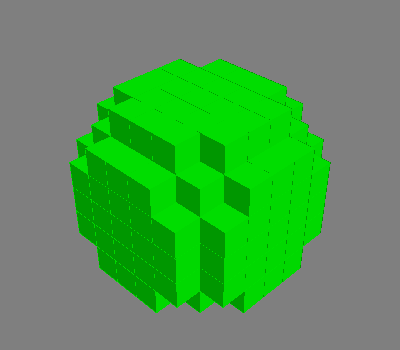

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (64, 1, 28, 28)
# dataset = Mnist3D('3d-mnist/full_dataset_vectors.h5')
# #train_data = x_train
#train_loader = Data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
# Load data
dataset = ToySpheres((6000, 1, 16, 16, 16), 1)

# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
# Num batches
num_batches = len(train_loader)

#test visualization
test_sphere = dataset[12].detach().numpy()
visualize3D(test_sphere, color=(0,1,1), thresh= 0.1)
visualize3D(test_sphere, color=(0,1,0), thresh= 0.1)

In [27]:
#Define AutoEncoder class

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, 3, stride=1),
            nn.ReLU(True),
            nn.MaxPool3d(2, stride=2),
            nn.Conv3d(64, 32, 3, stride=1),
            nn.ReLU(True),
            nn.MaxPool3d(2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(32, 64, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 4, 3, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose3d(4, 1, 4, stride=1),
            nn.ReLU(True),
            nn.Tanh()
        )
        
    def forward(self, val):
        encoded = self.encoder(val)
        print(encoded.shape)
        decoded = self.decoder(encoded)
        print(decoded.shape)
        return encoded, decoded
        
    def encode(self, val):
        val = self.encoder(val)
        return val.cpu().data

    def decode(self, val):
        val = self.decoder(val)
        return val.cpu().data

In [28]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
loss_func = nn.BCELoss()
#loss_func = nn.MSELoss()

In [31]:
for epoch in range(EPOCH):
    for step, (x) in enumerate(train_loader):
        print(step)
        # batch x, shape (batch, 28, 28)
        b_x = x + NOISE_VAL * torch.rand_like(x) / (1.0 + NOISE_VAL) # Renormalize with added noise

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, x)        # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            #_, decoded_data = autoencoder(view_data)
#             decoded_data = np.reshape(decoded_data.data.numpy()[0], (4, 16, 16, 16))
#             s = visualize3D(decoded_data, color=(0, 1, 1), percentile=0.85)
#             s
#             # initialize figure
#             f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))

#             for i in range(N_TEST_IMG):
#                 a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
#                 a[1][i].clear()
#                 a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
#                 a[1][i].set_xticks(()); a[1][i].set_yticks(())
#             plt.draw(); plt.pause(0.05)

0
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
Epoch:  0 | train loss: 3.1138
1
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
2
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
3
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
4
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
5
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
6
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
7
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
8
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
9
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
10
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
11
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
12
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
13
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
14
torch.Size([100, 32, 2, 2, 2])
torch.S

torch.Size([100, 1, 16, 16, 16])
2
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
3
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
4
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
5
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
6
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
7
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
8
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
9
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
10
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
11
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
12
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
13
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
14
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
15
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
16
torch.Size([100, 32, 2, 2, 2])
tor

torch.Size([100, 1, 16, 16, 16])
4
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
5
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
6
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
7
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
8
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
9
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
10
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
11
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
12
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
13
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
14
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
15
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
16
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
17
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
18
torch.Size([100, 32, 2, 2, 2])
t

torch.Size([100, 1, 16, 16, 16])
6
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
7
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
8
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
9
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
10
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
11
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
12
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
13
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
14
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
15
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
16
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
17
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
18
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
19
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
20
torch.Size([100, 32, 2, 2, 2])

torch.Size([100, 1, 16, 16, 16])
8
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
9
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
10
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
11
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
12
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
13
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
14
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
15
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
16
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
17
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
18
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
19
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
20
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
21
torch.Size([100, 32, 2, 2, 2])
torch.Size([100, 1, 16, 16, 16])
22
torch.Size([100, 32, 2, 2, 2